In [113]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [114]:
import numpy as np
import pandas as pd

In [115]:
import datetime as dt

# Part 1 - Prepare SQLAlchemy 

In [116]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [117]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [118]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
measurement_df = pd.read_sql('SELECT * FROM measurement', conn)
measurement_df

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [119]:
station_df = pd.read_sql('SELECT * FROM station', conn)
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Part 2 - Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

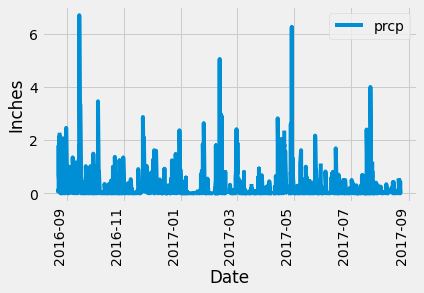

In [157]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurement_df.sort_values("date", ascending= False)

# Calculate the date 1 year ago from the last data point in the database


one_year = '2016-08-23'

# Perform a query to retrieve the data and precipitation scores
query = f'''
    SELECT 
        date,
        prcp 
    FROM 
        measurement 
    WHERE 
        date >= '{one_year}'
    ORDER BY 
        date
'''
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.read_sql(query, conn)

#Convert the date column to date
prcp_df['date'] = pd.to_datetime(prcp_df['date']) 

prcp_df.sort_values('date')
prcp_df = prcp_df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')

In [152]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [165]:
# How many stations are available in this dataset?
query = '''
SELECT COUNT(*) as station_count FROM station
'''

station_df = pd.read_sql(query, conn)

station_count = station_df['station_count'].values[0]

print(f'There are {station_count} stations in the database.')

There are 9 stations in the database.


In [194]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestations_df = pd.read_sql('SELECT count (*), station FROM measurement GROUP BY station ORDER BY count(*) desc', conn)
activestations_df

query = '''
    SELECT
        s.station AS station_code,
        s.name AS station_name,
        COUNT(*) as station_count
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    GROUP BY 
        s.station,
        s.name
    ORDER BY
        station_count DESC
'''

active_stations_df = pd.read_sql(query, conn)
active_stations_df.head()

,station_code,station_name,station_count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612


In [179]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

active_stations_df.sort_values('station_count', ascending=False, inplace=True)
most_active_station = active_stations_df['station_code'].values[0]
print(f'The most active station is {most_active_station}')

query = f'''
SELECT
    MIN(tobs) AS min_tobs,
    MAX(tobs) AS max_tobs,
    AVG(tobs) AS avg_tobs
FROM
    measurement
Where
    station = '{most_active_station}'
'''

temp_obs_df = pd.read_sql(query, conn)
temp_obs_df

The most active station is USC00519281


,min_tobs,max_tobs,avg_tobs
0,54.0,85.0,71.663781


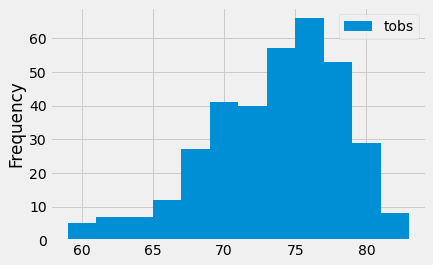

In [183]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = f'''
    SELECT
        date,
        tobs
    FROM
        measurement
    WHERE
        date >= (SELECT DATE(MAX(date),'-1 year') FROM measurement)
        AND station = '{most_active_station}'
    '''
temp_obs_df = pd.read_sql(query, conn)
temp_obs_df

temp_obs_df.plot.hist(bins=12)

## Part 3 - Data Analysis Assignment

In [70]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    
    return pd.read_sql('SELECT min(tobs),avg(tobs),max(tobs) FROM measurement WHERE date between "2012-02-28" and "2012-03-05"', conn)


# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.571429       74.0


In [191]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
    
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    query = f'''
        SELECT
            MIN(tobs) AS min_tobs,
            MAX(tobs) AS max_tobs,
            AVG(tobs) AS avg_tobs
        FROM
            measurement
        WHERE
            date BETWEEN '{start_date}' AND '{end_date}'
    '''

    temp_stats_df = pd.read_sql(query, conn)
    
    temp_stats = tuple(temp_stats_df.values[0])

    return temp_stats

print(calc_temps('2017-01-01', '2017-12-31'))

(58.0, 87.0, 74.14387974230493)


In [192]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = calctemp_previous["max(tobs)"]
tmin = calctemp_previous["min(tobs)"]
peak_to_peak = tmax - tmin # This will be our error line
tavg = calctemp_previous["avg(tobs)"] # This will be the height of our graph 
# Plot
fig, ax = plt.subplots(figsize = (5, 10)) 

# Create figure & axis objects 
ax.bar(x = 1, height = tavg, yerr = peak_to_peak/2, width = 0.2,color = 'r', alpha = 0.4) 

# Plotting
ax.set_xticks([0]) 
plt.yticks(size=14)
plt.ylabel("Temp (F)")
plt.title("Average Temp")
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [95]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

totalrainfall_df = pd.read_sql('select s.name, m.station, m.prcp, s.elevation, s.latitude, s.longitude from (Select station\
, ROUND(sum(prcp),2) prcp from measurement where date between "2016-08-23" and "2017-08-23" group by station) m \
join station s on m.station=s.station order by m.prcp desc' , conn)
totalrainfall_df


,name,station,prcp,elevation,latitude,longitude
0,"MANOA LYON ARBO 785.2, HI US",USC00516128,147.81,152.4,21.33310,-157.80250
1,"WAIHEE 837.5, HI US",USC00519281,70.03,32.9,21.45167,-157.84889
2,"KANEOHE 838.1, HI US",USC00513117,48.51,14.6,21.42340,-157.80150
3,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,38.01,19.5,21.33556,-157.71139
4,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,33.24,7.0,21.52130,-157.83740
5,"WAIKIKI 717.2, HI US",USC00519397,16.09,3.0,21.27160,-157.81680
6,"PEARL CITY, HI US",USC00517948,4.59,11.9,21.39340,-157.97510


In [97]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    
    return pd.read_sql('SELECT min(tobs),avg(tobs),max(tobs) FROM measurement WHERE date like "%01-%01"', conn)
    
daily_normals("01-01")

,min(tobs),avg(tobs),max(tobs)
0,62.0,69.153846,77.0


In [109]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime(2018,2,1)
end_date = dt.datetime(2018,2,15) 

# Use the start and end date to create a range of dates
date_list = pd.date_range(start_date, end_date).tolist()
date_list
dates=[]

# Stip off the year and save a list of %m-%d strings
for date in date_list:
    dates.append (dt.datetime.strftime(date, '%m-%d')) 
normals=[]

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dates:
    normals.append(daily_normals(date))
print("My Vacation Date: February 01 through February 15")
for normal in normals:
    print(normal)

My Vacation Date: February 01 through February 15
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0       62.0  69.153846       77.0
   min(tobs)  avg(tobs)  max(tobs)
0    

In [110]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_temp=[]
for normal in normals:
    normal_temp.append(np.ravel(normal))
travel_df = pd.DataFrame(normal_temp, columns=['min(tobs)', 'avg(tobs)', 'max(tobs)'])
travel_df.index=[str(date.strftime('%Y-%m-%d')) for date in date_list]
travel_df

,min(tobs),avg(tobs),max(tobs)
2018-02-01,62.0,69.153846,77.0
2018-02-02,62.0,69.153846,77.0
2018-02-03,62.0,69.153846,77.0
2018-02-04,62.0,69.153846,77.0
2018-02-05,62.0,69.153846,77.0
2018-02-06,62.0,69.153846,77.0
2018-02-07,62.0,69.153846,77.0
2018-02-08,62.0,69.153846,77.0
2018-02-09,62.0,69.153846,77.0
2018-02-10,62.0,69.153846,77.0


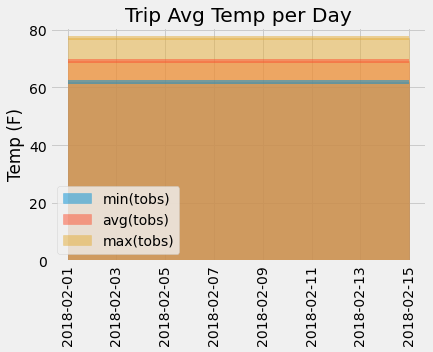

In [111]:
# Plot the daily normals as an area plot with `stacked=False`
ax = travel_df.plot.area(stacked=False, rot=90)
plt.yticks(size=14)
plt.ylabel("Temp (F)")
plt.title("Trip Avg Temp per Day")
plt.show()